Работу выполнил Данил Исламов (Stepik ID: 274397404)

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [ ]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies** (множество тегов данной системы показано на изображении ниже). Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


**N.B.**: Universal Tagset, применяемый в NLTK (и по которому, соответственно, размечен используемый в задании датасет), — это **не** Universal Dependencies. Множество тегов Universal Tagset-а NLTK можно посмотреть в [таблице](http://www.nltk.org/book/ch05.html#tab-universal-tagset)

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Мы имеем массив предложений, составленных из пар (слово-тег) — т.е. каждому слову предложения сопоставлена его часть речи

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частотой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
fdist_tags = nltk.FreqDist(tag for (word, tag) in brown_tagged_words)
fdist_words = nltk.FreqDist(word for (word, tag) in brown_tagged_words)

print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tags_freq = {tag: fdist_tags[tag] for tag in tags}
words_freq = {word: fdist_words[word] for word in words}

tag_num = pd.Series(data=tags_freq).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(data=words_freq).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [ ]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

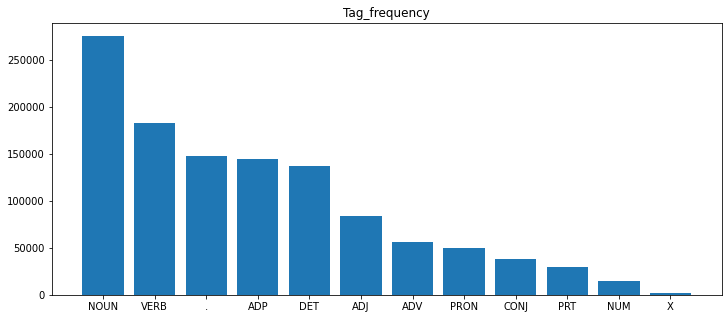

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

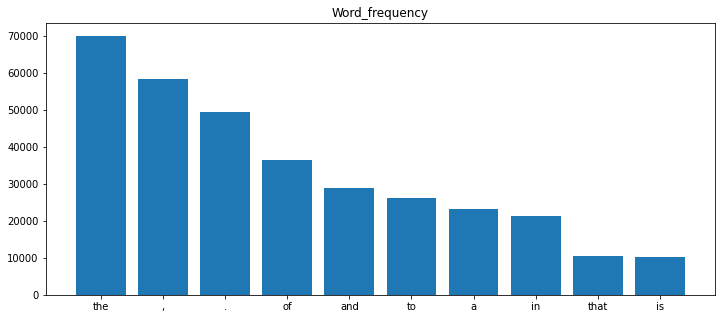

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?
* Ответ: 23

In [ ]:
word_num['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете все слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

* Ответ: "time"

Поскольку каждому из слов могут быть присвоены разные теги в зависимости от контекста, будем искать "самое популярное слово с самым популярным тегом" следующим образом:

1. Найдём все слова, которые хотя бы раз получали самый популярный тег (как уже было выяснено выше, этот тег — "NOUN")
2. Отсортируем полученный массив по убыванию частоты появления слова
3. Получим слова из отсортированного массива и в качестве "самого популярного" возьмём первое из них, которое (на мой взгляд) однозначно принадлежит к выбранной части речи

In [ ]:
word2tag = pd.Series(tags, index=words)
MostFreqTag_words = word2tag.loc[lambda x: x == tag_num.index[0]]
MostFreqTag_words = MostFreqTag_words.sort_index(key=lambda x: word_num[x], ascending=False)
MostFreqTag_words.index.unique()[:15]

Index(['to', 'a', 'in', 'for', 'i', 'one', 'will', 'more', ':', 'can', 'time',
       'may', 'do', 'my', 'man'],
      dtype='object')

Видно, что список самых популярных слов, хотя бы раз получивших тег "NOUN", включает в себя такие слова, как "to", "for", "will" и даже ":", которые явно не назовёшь существительными даже с натяжкой. Поэтому выберу слово "time" — кажется, это первое слово в списке, с определением тега которого не должно возникать никаких проблем. Но на всякий случай проверим, какие ему присваивались теги:

In [ ]:
word2tag.loc['time'].unique()

array(['NOUN', 'VERB'], dtype=object)

Похоже, что с определением части речи для "time" тоже возникали ошибки — по крайней мере, для меня сложно представить, где оно могло служить глаголом. Посмотрим на частоты возникновения обоих тегов для этого слова.

In [ ]:
word2tag.loc['time'].describe()

count     1598
unique       2
top       NOUN
freq      1597
dtype: object

Получается, что из 1598 появлений слова "time", 1597 раз ему был присвоен тег "NOUN" и 1 раз — "VERB", что явно было ошибкой. Так что всё же остановлюсь на нём, как на "самом популярном слове с самым популярным тегом".

---

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только с текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
len(train_sents)

947

In [ ]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово-тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег — слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамического программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:    
    def __init__(self):
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений, составленных из пар слово-тег (выборка для train) 
        """

        fdist_tags = nltk.FreqDist(tag for sent in train_tokens_tags_list
                                   for (word, tag) in sent)
        fdist_words = nltk.FreqDist(word for sent in train_tokens_tags_list
                                    for (word, tag) in sent)
        
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tags_freq = {tag: fdist_tags[tag] for tag in tags}
        words_freq = {word: fdist_words[word] for word in words}

        tag_num = pd.Series(data=tags_freq).sort_index()
        word_num = pd.Series(data=words_freq).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index


        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицы A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] — i-е слово в этом предложении, sent[i][1] — i-й тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # i-я пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем возможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем возможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений, составленных из пар слово-тег (test выборка)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            # Массив, содержащий максимальные вероятности возникновения последовательности
            # длины t, заканчивающейся тегом s
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем тегам s)
            
            # Массив, содержащий последний тег (s') последовательности длины t-1,
            # при котором максимизируется вероятность возникновения q[t][s]
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = 'time'
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1) 
                    q[t + 1][i_s] = np.max(q[t] * 
                                           self.A.loc[:, s] * 
                                           self.B.loc[current_sent[t], s])
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s]).reset_index()[s].idxmax() # индекс 

                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [ ]:
my_model = HiddenMarkovModel()
my_model = my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], 
         ['a', 'cat', 'and', 'a', 'dog'], 
         ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
for i, s in enumerate(sents):
    for j, w in enumerate(s):
        sents[i][j] = w.lower()
my_model.predict(sents)

OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

На мой взгляд, модель справилась со своей задачей достаточно хорошо, большинство слов были размечены правильно. Однако, есть один странный момент: слово "favourite" в последнем предложении было расценено как "NOUN", хотя в данном контексте оно должно принадлежать к "ADJ". Чтобы разобраться в причинах, для начала посмотрим, какими тегами помечалось данное слово во всём датасете, т.к. при поиске самого популярного слова с самым популярным тегом было выявлено, что датасет размечен с ошибками:

In [ ]:
try:
    print(word2tag.loc['favourite'].unique())
except KeyError:
    print('No such word')

No such word


Получается, что в используемом датасете ни разу не встречалось слово "favourite", а значит, оно было заменено на самое популярное слово с самым популярным тегом — "time", которое, как было показано в ответе на вопрос 2, почти всегда определяется как "NOUN". Кроме того, слова типа "DET" всегда предваряют появление существительных (хотя между ними могут быть и другие слова, те же "ADJ"), поэтому вероятность появления слова с тегом "NOUN" тут тоже должна быть высока, так что предсказание модели вполне ожидаемо.

Тем не менее, кажется странным, что слово "favourite" не встретилось ни в одном из почти 1000 предложений тренировочного датасета. Попробуем сделать поправку на британский-американский английский:

In [ ]:
try:
    print(word2tag.loc['favorite'].unique())
except KeyError:
    print('No such word')

['ADJ' 'NOUN']


А вот теперь такое слово нашлось, да ещё и с правильным тегом (хотя, оно действительно может быть и существительным). Сделаем ещё одно предсказание на последнем предложении из примеров, заменив "favourite" на "favorite".

In [ ]:
sents = [['My', 'favorite', 'character']]
for i, s in enumerate(sents):
    for j, w in enumerate(s):
        sents[i][j] = w.lower()
my_model.predict(sents)

OrderedDict([(0, array(['DET', 'ADJ', 'NOUN'], dtype='<U4'))])

В этот раз всё получилось так, как и должно быть. Таким образом, заключу, что на всех примерах модель показала отличный результат

### Вопрос 3:
* Какой тег вы получили для слова `can`?
* Ответ: "VERB"

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?
* Ответ: Для "favourite" — "NOUN"; для "favorite" — "ADJ"

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [ ]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [pair[1] for pair in sent]
        words = [pair[0] for pair in sent]

        tags_pred = model.predict([words])[0]

        true_pred += sum([tags_pred[i] == tags[i] for i in range(len(tags))])
        num_pred += len(tags)
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [ ]:
accuracy_score(my_model, test_sents)

Accuracy: 88.82847256549678 %


На мой взгляд, модель показала достаточно высокую accuracy. Тем не менее, примерно 11%-ам слов был присвоен неправильный тег — возможно, это было связано с ошибками в разметке самого датасета, которые были обнаружены в предыдущих пунктах задания; так же стоит иметь в виду тот факт, что модель заменяла незнакомые слова, которые вполне могли встретиться, на "time", предсказывая на них (скорее всего) тег "NOUN" — а правильный тег неизвестного слова мог быть и другим. Эти факторы кажутся мне наиболее явными причинами ошибок модели. Однако, повторюсь, качество (по данной метрике, разумеется) всё равно довольно высокое.

### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?
* Ответ: 88.8%

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train (округлите до одного знака после запятой)?

* Ответ: 20.2%

Вы можете использовать DefaultTagger (метод .tag для предсказания частей речи предложения)

In [ ]:
# Самый популярный тег на train выборке 
nltk.FreqDist(tag for sent in train_sents for (word, tag) in sent).max()

'NOUN'

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger("NOUN")

In [ ]:
true_pred = 0
num_pred = 0

for sent in test_sents:

    true_tags = [pair[1] for pair in sent]
    test_words = [pair[0] for pair in sent]

    tags_pred = default_tagger.tag(test_words)

    true_pred += sum([tags_pred[i][1] == true_tags[i] for i in range(len(test_words))])
    num_pred += len(test_words)
    
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 20.217498764211566 %


## NLTK, RNNMorph

### NLTK

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тегов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Сделаем предсказания данной моделью на тех же примерах, на которых "тестировали взглядом" HMM

In [ ]:
sents = [['He', 'can', 'stay'], 
         ['a', 'cat', 'and', 'a', 'dog'], 
         ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

for sent in sents:
    tags_pred = nltk.pos_tag(sent, tagset='universal')
    print(tags_pred)

[('He', 'PRON'), ('can', 'VERB'), ('stay', 'VERB')]
[('a', 'DET'), ('cat', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('dog', 'NOUN')]
[('I', 'PRON'), ('have', 'VERB'), ('a', 'DET'), ('television', 'NOUN')]
[('My', 'PRON'), ('favourite', 'ADJ'), ('character', 'NOUN')]


Кроме правильно определённой части речи favourite, никаких отличий от предсказаний HMM нет

In [ ]:
true_pred = 0
num_pred = 0

for sent in test_sents:

    true_tags = [pair[1] for pair in sent]
    test_words = [pair[0] for pair in sent]

    tags_pred = nltk.pos_tag(test_words, tagset='universal')

    true_pred += sum([tags_pred[i][1] == true_tags[i] for i in range(len(test_words))])
    num_pred += len(test_words)

print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 89.22392486406328 %


Однако, accuracy данной модели хоть и ненамного, но оказалась выше, чем у HMM

### RNNMorph

In [ ]:
!pip install rnnmorph

In [ ]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

In [ ]:
true_pred = 0
num_pred = 0

# Будем собирать встречающиеся теги во множество для сравнения со множеством 
# тегов Universal Tagset из NLTK
rnnmorph_tags = set()

for sent in test_sents:

    true_tags = [pair[1] for pair in sent]
    test_words = [pair[0] for pair in sent]

    tags_pred = predictor.predict(test_words)

    true_pred += sum([tags_pred[i].pos == true_tags[i] for i in range(len(test_words))])
    num_pred += len(test_words)

    for t in tags_pred:
        rnnmorph_tags.add(t.pos)

print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 62.827483934750376 %


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тeгов. Какие здесь отличия?

* Ответ: 
        nltk.pos_tag: 89.2%; 
        RNNMorphPredictor: 62.8%. 

RNNMorphPredictor показал значительно более низкую accuracy, нежели nltk.pos_tag и HiddenMarkovModel. Однако, если сравнивать его результат с DefaultTagger (accuracy которого была всего 20.2%), становится понятно, что модель всё-таки предсказывала правильные классы достаточно часто, а значит, улавливала определённые закономерности. Относительно низкий показатель качества же вполне мог быть следствием различий в используемых системах тегов. Чтобы проверить это, посмотрим на предсказания NLTK и RNNMorph на тех же примерах, которые использовались для проверки работы HiddenMarkovModel, после чего сравним множества тегов, которые эти модели присваивали словам из test датасета (спойлер: RNNMorph использует систему Universal Dependencies, которая, как было отмечено в самом начале ноутбука, отличается от Universal Tagset из NLTK).

In [ ]:
sents = [['He', 'can', 'stay'], 
         ['a', 'cat', 'and', 'a', 'dog'], 
         ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

for i, s in enumerate(sents):
    for j, w in enumerate(s):
        sents[i][j] = w.lower()
    
    print(f'Sentence {i + 1}:')
    
    print(f'RNNMorph: ', end='\t')
    for p in predictor.predict(s):
        print(p.pos, end='\t')
    print()
     
    print(f'NLTK: ', end='\t\t') 
    for _, pos in nltk.pos_tag(s, tagset='universal'):
        print(pos, end='\t')
    print()

    print()

Sentence 1:
RNNMorph: 	PRON	AUX	VERB	
NLTK: 		PRON	VERB	VERB	

Sentence 2:
RNNMorph: 	DET	NOUN	CCONJ	DET	NOUN	
NLTK: 		DET	NOUN	CONJ	DET	NOUN	

Sentence 3:
RNNMorph: 	PRON	VERB	DET	NOUN	
NLTK: 		NOUN	VERB	DET	NOUN	

Sentence 4:
RNNMorph: 	PRON	ADJ	NOUN	
NLTK: 		PRON	ADJ	NOUN	



Видно, что, в целом, модели показали одинаковые результаты, при этом кое-где RNNMorph, на мой взгляд, оказался даже точнее. Так, в первом предложении RNNMorph присвоил слову "can" тег "AUX", что является более точным (т.к. "can" принадлежит к модальным глаголам, которые включаются в так называемые "auxiliary verbs" — "AUX"), чем объемлющее понятие "VERB", к которому "can" было отнесено и в самом brown датасете, и в предсказании модели из NLTK. Аналогичная ситуация получилась и с тегом слова "and" во втором предложении: "CCONJ", присвоенный RNNMorph, обозначает сочинительный союз, к которым относятся "and", "but" и "or". Тег "CONJ" же, обозначающий союзы в целом, является более широким по охвату и от того может трактоваться как менее точный. Также можно заметить, что для слова "I" в третьем предложении RNNMorph предсказал тег "PRON" — здесь без лишних комментариев, тег "NOUN", назначенный NLTK, явно ошибочен. Других отличий в предсказаниях не наблюдается.

Теперь сравним множества тегов, присвоенных словам из тестового датасета моделями RNNMorph и NLTK.

In [ ]:
rnnmorph_tags_copy = rnnmorph_tags.copy()

In [ ]:
rnnmorph_tags = list(rnnmorph_tags)
rnnmorph_tags.sort()
rnnmorph_tags = pd.DataFrame(rnnmorph_tags)

universal_tags = pd.DataFrame(tag_num.index.sort_values())

tags_compar = pd.concat([rnnmorph_tags, universal_tags], axis=1).fillna('_')
tags_compar.columns = ['RNNMorph tags', 'Universal tags']
print(tags_compar)

   RNNMorph tags Universal tags
0            ADJ              .
1            ADP            ADJ
2            ADV            ADP
3            AUX            ADV
4          CCONJ           CONJ
5            DET            DET
6           INTJ           NOUN
7           NOUN            NUM
8            NUM           PRON
9           PART            PRT
10          PRON           VERB
11         PROPN              X
12         PUNCT              _
13         SCONJ              _
14          VERB              _
15             X              _


Очевидно, что множество тегов Universal Dependencies, используемое RNNMorph, больше множества тегов Universal Tagset из NLTK — например, как уже было указано выше, глаголы в нём разделяются на категории "AUX" и "VERB"; союзы — на "CCONJ" и "SCONJ", тег "INTJ", отмечающий междометия, в тегсете NLTK не представлен вообще, а пунктуация просто обозначена разными способами — "PUNCT" у RNNMorph и "." у NLTK. Таким образом, из-за использования более тонкой системы тегов — т.е. делающей значительно меньше обобщений — и некоторых отличий в названиях тегов, предсказания RNNMorph могли конфликтовать с разметкой датасета, фактически, не уступая ей в качестве, а где-то, возможно, и превосходя. По этой причине считаю, что в данном случае оценивать рассмотренную модель метрикой accuracy некорректно, как и сравнивать её показатели с показателями других моделей, предсказывающих теги той же системы, по которой был размечен датасет.

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:
from torchtext.legacy.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извеcтны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], 
                                                           fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря использyем только **train**

In [ ]:
WORD.build_vocab(train_data, min_freq=5)
TAG.build_vocab(train_data)

print(f"Number of unique tokens in vocabulary: {len(WORD.vocab)}")
print(f"Number of tags: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Number of unique tokens in vocabulary: 391
Number of tags: 13
['<unk>', 'use']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'ADJ', 'PRON', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [ ]:
print(vars(train_data.examples[9]))

{'words': ['the', 'girl', 'nodded', 'understandingly', '.'], 'tags': ['DET', 'NOUN', 'VERB', 'ADV', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

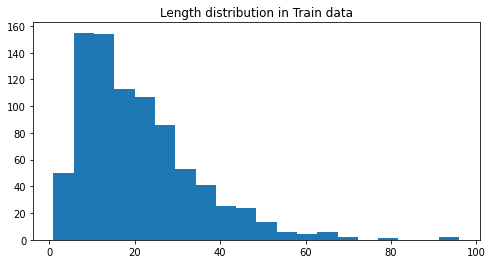

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:
# Разбиваем нашу выборку на батчи, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, 
                 dropout, bidirectional=False):
        super().__init__()       
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.rnn = nn.LSTM(input_size=emb_dim,
                           hidden_size=hid_dim,
                           num_layers=num_layers,
                           dropout=dropout,
                           bidirectional=bidirectional)
        
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)

        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)

        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 300
HID_DIM = 100
NUM_LAYERS = 2
DROPOUT = 0.5
BIDIRECTIONAL = False

model = LSTMTagger(input_dim=INPUT_DIM,
                   emb_dim=EMB_DIM,
                   hid_dim=HID_DIM,
                   output_dim=OUTPUT_DIM,
                   num_layers=NUM_LAYERS,
                   dropout=DROPOUT,
                   bidirectional=BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(391, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 100, num_layers=2, dropout=0.5)
  (tag): Linear(in_features=100, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 360,213 trainable parameters


Погнали обучать

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        words = batch.words.to(device)
        # Сразу разворачиваем теги в одномерный тензор, т.к. CrossEntropyLoss
        # требует именно такого представления
        tags = batch.tags.to(device).view(-1)

        optimizer.zero_grad()
        
        #tags = [sent len * batch size]
        #tags_pred = [sent len, batch size, output dim]
        
        tags_pred = model(words)
        # Разворачиваем предсказанные теги аналогично правильным, только теперь
        # тензор будет двумерным, размерности [sent len * batch size, output dim]
        tags_pred = tags_pred.view(-1, tags_pred.size()[-1])

        #tags = [sent len * batch size]
        #tags_pred = [sent len * batch size, output dim]
        
        loss = criterion(tags_pred, tags)
        
        loss.backward()
        
        # Gradient clipping (решение проблемы взрыва градента), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()

        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())  

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            words = batch.words.to(device)
            tags = batch.tags.to(device).view(-1)

            #tags = [sent len * batch size]
            #tags_pred = [sent len, batch size, output dim]

            tags_pred = model(words).detach()
            tags_pred = tags_pred.view(-1, tags_pred.size()[-1])

            #tags = [sent len * batch size]
            #tags_pred = [sent len * batch size, output dim]

            loss = criterion(tags_pred, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

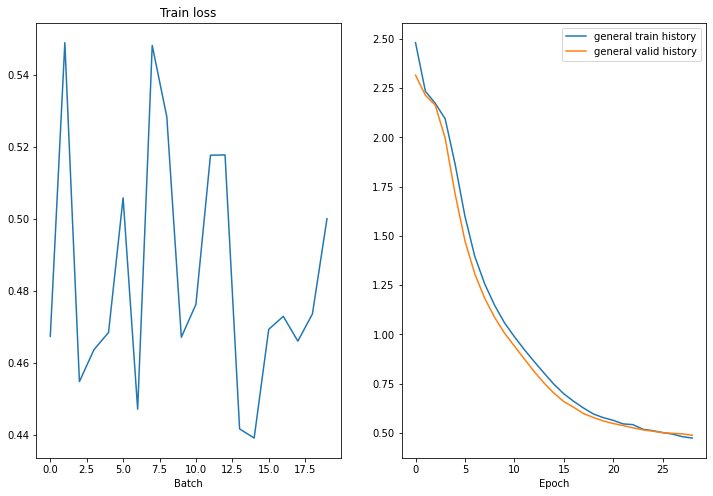

Epoch: 30 | Time: 0m 1s
	Train Loss: 0.475 | Train PPL:   1.608
	 Val. Loss: 0.486 |  Val. PPL:   1.626


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 30
CLIP = 2
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [ ]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            words = batch.words.to(device)
            tags = batch.tags.to(device)
            
            #tags_pred = [sent len, batch size, output dim]
            tags_pred = model(words).detach()
            tags_pred = torch.argmax(tags_pred, dim=-1)
            
            #tags_pred = [sent len, batch size]
            tags_pred = tags_pred.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == tags_pred) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 85.52 %


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам необходимо взять всю выборку, а не только категорию `humor`.

Вам необходимо добиться качества не меньше, чем `accuracy = 93 %` 

Пример решения нашей задачи:

In [ ]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [ ]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             PRT
gauge          VERB
in             ADP
a              DET
swift          NOUN
,              .
greedy         NOUN
glance         NOUN
,              .
the            DET
figure         NOUN
inside         NOUN
the            DET
coral-colored  NOUN
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


Видно, что на данном примере модель совершает очень много ошибок, да и accuracy оставляет желать лучшего, однако повысить качество на данном примере мне не удалось, а accuracy значительно возрастала только в случае явного переобучения модели.

## Сравните результаты моделей HiddenMarkov, LSTMTagger:
* при обучении на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

Результаты каждой из моделей на предложениях категории humor у нас уже есть, поэтому теперь обучим их на всём корпусе и подведём итоги

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [ ]:
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


### HMM

In [ ]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

In [ ]:
sents = [['He', 'can', 'stay'], 
         ['a', 'cat', 'and', 'a', 'dog'], 
         ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
for i, s in enumerate(sents):
    for j, w in enumerate(s):
        sents[i][j] = w.lower()
my_model.predict(sents)

OrderedDict([(0, array(['PRON', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['PRON', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['DET', 'NOUN', 'NOUN'], dtype='<U4'))])

Никаких изменений по сравнению с предсказаниями модели, обученной на категории humor, не наблюдается

In [ ]:
accuracy_score(my_model, test_sents)

Accuracy: 96.26295331104619 %


А вот accuracy значительно подросла с прошлого раза

### NLTK

Протестируем заодним и POS-tagger из NLTK, чтобы было с чем сравнить остальные модели и чтобы понять, стоит ли тратить время на прописывание алгоритмов, их настройку/обучение, или можно просто взять tagger "из коробки".

In [ ]:
true_pred = 0
num_pred = 0

for sent in test_sents:

    tags = [pair[1] for pair in sent]
    words = [pair[0] for pair in sent]

    tags_pred = nltk.pos_tag(words, tagset='universal')

    true_pred += sum([tags_pred[i][1] == tags[i] for i in range(len(tags))])
    num_pred += len(tags)

print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 90.69730711521757 %


Accuracy на всём датасете почти не отличается от таковой на категории humor 

### LSTM

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]

WORD = Field(lower=True)
TAG = Field(unk_token=None)

examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], 
                                                           fields=[('words', WORD), ('tags', TAG)]))
    
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

WORD.build_vocab(train_data, min_freq=5)
TAG.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 300
HID_DIM = 100
NUM_LAYERS = 2
DROPOUT = 0.5
BIDIRECTIONAL = False

model = LSTMTagger(input_dim=INPUT_DIM,
                   emb_dim=EMB_DIM,
                   hid_dim=HID_DIM,
                   output_dim=OUTPUT_DIM,
                   num_layers=NUM_LAYERS,
                   dropout=DROPOUT,
                   bidirectional=BIDIRECTIONAL).to(device)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(12281, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 100, num_layers=2, dropout=0.5)
  (tag): Linear(in_features=100, out_features=13, bias=True)
)

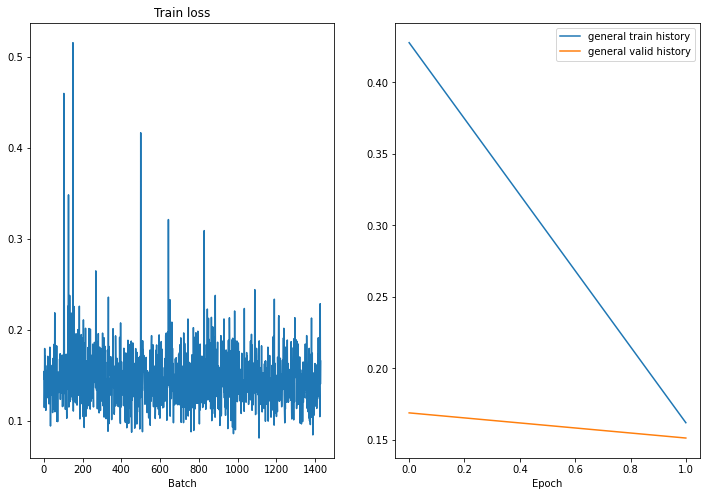

Epoch: 03 | Time: 1m 34s
	Train Loss: 0.146 | Train PPL:   1.157
	 Val. Loss: 0.142 |  Val. PPL:   1.153


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 2
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 94.89 %


In [ ]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93

Теперь accuracy получилась значительно выше, чем на категории "humor"; как и в прошлый раз, при переобучении модели она продолжала расти. Оценим работу модели на примерах и сравним с предсказаниями LSTM, обученной только на категории "humor":

In [ ]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             PRT
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  NOUN
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


На данном примере изменения, в целом, положительные: слова "swift", "greedy" и "inside" теперь получили правильные теги, хотя при этом тег слова "gauge", наоборот, был заменён на неправильный. В остальном различий между предсказаниями моделей нет. Следующим пунктом сделаем ради интереса предсказания на тех же предложениях, на которых оценивали работу HMM

In [ ]:
sents = [(['He', 'can', 'stay'], 0),
         (['a', 'cat', 'and', 'a', 'dog'], 0), 
         (['I', 'have', 'a', 'television'], 0),
         (['My', 'favourite', 'character'], 0)]

for s in sents:
    print_tags(model, s)
    print()

He             NOUN
can            VERB
stay           VERB

a              DET
cat            NOUN
and            CONJ
a              DET
dog            NOUN

I              NOUN
have           VERB
a              DET
television     NOUN

My             NOUN
favourite      NOUN
character      NOUN



Несмотря на возросшую accuracy, качество предсказаний модели на данных примерах сильно уступает HMM

### Итоги

Посмотрим ещё раз на результаты моделей HMM, NLTK и LSTM.

In [ ]:
models_results = pd.DataFrame({'Humor':{'HMM': 88.83,
                                        'NLTK': 89.22, 
                                        'LSTM tagger': 85.52}, 
                               'All categories': {'HMM': 96.26,
                                                  'NLTK': 90.70,
                                                  'LSTM tagger': 94.89}})

In [ ]:
models_results

,Humor,All categories
HMM,88.83,96.26
NLTK,89.22,90.70
LSTM tagger,85.52,94.89


Результаты показали, что и на отдельной категории корпуса (humor), и на всём датасете accuracy у HMM оказалась выше, чем у LSTM, при этом разница в показателях моделей оказалась заметно меньше при использовании всего датасета. Любопытно, что POS-tagger NLTK показал примерно одинаковое качество в обоих экспериментах, обогнав по accuracy и HMM, и LSTM на категории humor, но сильно отстав от них на всём корпусе. 

Сравнивая отдельно HMM и LSTM, на мой взгляд, лучше с задачей справилась модель HiddenMarkov, показавшая более высокую accuracy и сделавшая более "адекватные" предсказания на паре рассмотренных примеров. Возможно, изменив гиперпараметры/архитектуру LSTM или увеличив количество данных для обучения, можно было бы добиться на ней и более высокого качества, однако в моих экспериментах достичь этого не удалось — как уже было отмечено, accuracy заметно возрастала только при явном переобучении. С точки зрения ресурсозатратности, настройка параметров HMM (вычисление матриц A и B) занимала время, сравнимое с таковым для обучения LSTM, из-за чего явного фаворита по данному критерию выявить сложно. Однако стоит отметить, что HMM не требовала перебора гиперпараметров для выбора оптимального сочетания, что значительно сократило время для её "разогрева". 

Таким образом, в случае малого количества данных я бы выбрал POS-tagger из NLTK, т.к. он не требует обучения и выдаёт вполне приемлемое качество, тогда как для нормального обучения других моделей данных может просто не хватить. Если же данных достаточно для какого-никакого обучения (скажем, примерно столько же или больше, чем было в категории humor), то лучше использовать HMM — она показала лучшее качество, чем POS-tagger NLTK и LSTM при тестировании на всём датасете, не сильно уступила теггеру NLTK на категории humor, и при этом не требовала много времени на обучение.